In [1]:
#For model data
import sys
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt


#for calculating time difference
from datetime import datetime, timedelta

#For plotting
#import hvplot.xarray

#for saving output
import csv
import os

#for exporting displacement as lat2, lon2
from osgeo import gdal
from osgeo import osr

#For calculating integrated drift using passive trackers method
from scipy.interpolate import RegularGridInterpolator

#Tools for evaraging model data
sys.path.append(r'./tools')

**model_drift_export.ipynb** - see Displacement_calculation_Barents for the original draft file

<< description >>

Process model data for their further input into the warping (forecasting) algorithm.

<< structure >>
- Read NetCDF data for the time period related to SAR1 and SAR2 timestamps (forecasting period)*
- Calculate the time difference for the forecasting period (start time corresponds to SAR1 image timestamp, end time is defined by SAR2 timestamp for the experiment or end of modeling period)
- Extract needed variables and clip them according to the time and space** frame
- Calculate hourly displacement for drift- or/and image-driven warping***

***

*<font color="red">Notes below turned into article methodology chapter</font>*

**Each NetCDF file in the Barents2.5 model contains 6 ensembles and is released every 6 hours. In total, there are 24 ensembles that cover all 24 hours starting respectively at 00, 06, 12, and 18. Each forecast goes into the future for the next 66 hours with a one-hour step.  Velocities are instantaneous, they represent a 90sec average at every hour, and values in between are not stored.* 

*This experiment uses one ensemble output from the NetCDF file closest in time to the SAR1 image - barents_eps_20221119T06Z.nc. Ensemble 8 was chosen out of 6 ensembles presented in this NetCDF file as one with the least distortions for the area of interest. Distortions are mainly caused by vortex high-resolution drift.*

*To use the whole capability of 24 ensembles sliding average of all 24 ensembles can be used. Every 6 hours new 6 ensembles are added to averaging and the oldest 6 ensembles are excluded (not done for this experiment).*

***Model data are clipped according to tiff extent with some extra buffer zone to take drift into account. Subset of the whole image is used for the experiment for computational lighting.*

****Two types of displacement are calculated:*

*1) **for drift-driven warping** - hourly mean displacements integrated for the time period starting at SAR1 acquisition time to every next hour till the end of the warping (forecasting) period. They are applied every time on the original image.*

*2) **for image-driven warping** - hourly mean displacements which are later applied, first, on the original image and then to every next warping (forecasting) output respectively till the end of the forecasting period (or SAR2 timestamp). Such warping accumulates deformation information for each hour during the forecasting period. Even though geometrically the total deformation is the sum of hourly deformation vectors, theoretically calculating just it over a long time period might lead to misleading information. For example, strong convergence happening during 12 hours and changed by divergence for the other 12 hours will give near zero total deformation for 24 hours but the ice we see on the image can change a lot (especially in the coastal areas). Such an image-driven approach can help to preserve such information, for example by accumulating distorted areas during all 24 hours. On another hand, it can affect the result in the opposite direction if there are a lot of false high-resolution deformations. It might lead to too distorted image. Additionally, the quality of the image decreases with every iteration which after 24 hours provides a blurrier picture than in drift-driven warping. To find out which method is better might be an aim of this or the following step of the research. But no matter which method is used, it might be important to spatially accumulate deformation information for each hour (similar to what Luisa von Albedyll did with real divergence, leads opening events) and see if it adds information to compare with the total deformation field. It can be used for specifying less reliability of the areas with more deformation*

***

<< output >>

The output is two datasets 26 files each. The first and the last files contain not hourly but partial displacements that are calculated as a fraction of the average hourly displacement based on SAR images timestamps. 
The output format is a CSV file with 4 columns: [lon1, lat1, lon2, lat2] for input to the Forecasting algorithm or [x, y, dx, dy] for QGIS plotting


### Exporting data and variables
-describe in points

In [2]:
# Upload Barents2.5 data starting on 2022.11.19 at O6:00

data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20221119T06Z.nc")

In [3]:
data

<xarray.Dataset>
Dimensions:                  (ensemble_member: 6, s_rho: 42, s_w: 43, time: 67,
                              X: 739, Y: 949, depth: 1)
Coordinates:
  * time                     (time) datetime64[ns] 2022-11-19T06:00:00 ... 20...
  * X                        (X) float32 2.786e+05 2.811e+05 ... 2.124e+06
  * Y                        (Y) float32 -8.979e+05 -8.954e+05 ... 1.472e+06
  * depth                    (depth) float64 0.0
  * ensemble_member          (ensemble_member) int32 6 7 8 9 10 11
    lon                      (Y, X) float64 ...
    lat                      (Y, X) float64 ...
Dimensions without coordinates: s_rho, s_w
Data variables: (12/21)
    hc                       (ensemble_member) float64 ...
    Cs_r                     (ensemble_member, s_rho) float64 ...
    Cs_w                     (ensemble_member, s_w) float64 ...
    forecast_reference_time  (ensemble_member) datetime64[ns] ...
    projection_lambert       (ensemble_member) int32 ...
    h                        (ensemble_member, Y, X) float64 ...
    ...                       ...
    Uwind                    (time, ensemble_member, Y, X) float32 ...
    Vwind                    (time, ensemble_member, Y, X) float32 ...
    ice_concentration        (time, ensemble_member, Y, X) float32 ...
    ice_thickness            (time, ensemble_member, Y, X) float32 ...
    ice_u                    (time, ensemble_member, Y, X) float32 ...
    ice_v                    (time, ensemble_member, Y, X) float32 ...
Attributes: (12/32)
    file:                            /lustre/storeB/project/fou/hi/oper/baren...
    Conventions:                     CF-1.4, SGRID-0.3
    type:                            ROMS/TOMS history file
    title:                           Barents-2.5km - ROMS
    var_info:                        /home/havis/sea/ROMS/metroms_apps/barent...
    rst_file:                        /lustre/storeB/project/fou/hi/oper/baren...
    ...                              ...
    tiling:                          003x036
    ana_file:                        ROMS/Functionals/ana_btflux.h, ROMS/Func...
    CPP_options:                     BARENTS, ADD_FSOBC, ADD_M2OBC, ALBEDO, A...
    history:                         Sat Nov 19 12:39:55 2022: ncpdq -O -a ti...
    NCO:                             netCDF Operators version 4.7.9 (Homepage...
    DODS_EXTRA.Unlimited_Dimension:  time

In [15]:
# Extract variables

# General variables
X = data['X']
Y = data['Y']
lon = data['lon']
lat = data['lat']
time = data['time']
model_proj4 = data.projection_lambert.proj4

# Sea ice related variables
ensemble_member = data['ensemble_member']
ice_u = data['ice_u'] # ice velocity (x) 
ice_v = data['ice_v'] # ice velocity (y)
siconc = data['ice_concentration'] # ice area  (aggregate)

# Other variables
u = data['u'] # sea water x velocity
v = data['v'] # sea water y velocity
Uwind = data['Uwind'] # surface u-wind component
Vwind = data['Vwind'] #surface v-wind component


print(f'Model projection is {data.projection_lambert.grid_mapping_name} \nwith the following parameters in proj4 format: {model_proj4}')

Model projection is lambert_conformal_conic 
with the following parameters in proj4 format: +proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06


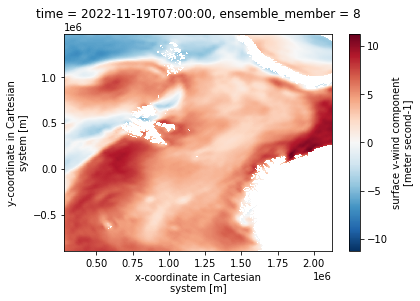

In [16]:
# Some examples of plotted varibles

Vwind.sel(time='2022-11-19T07:00:00',ensemble_member = 8).plot()

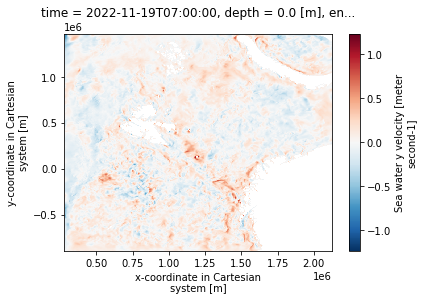

In [17]:
v.sel(time='2022-11-19T07:00:00',ensemble_member = 8).plot()

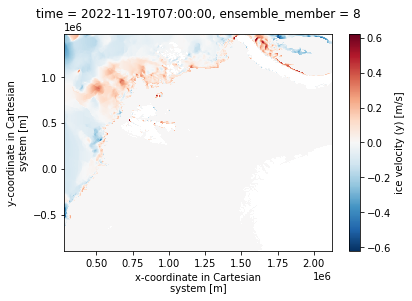

In [18]:
ice_v.sel(time='2022-11-19T07:00:00',ensemble_member = 8).plot()

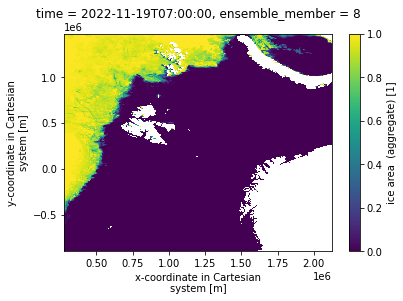

In [19]:
siconc.sel(time='2022-11-19T07:00:00',ensemble_member = 8).plot()

### Preparing time data

- Exporting time period corresponding to SAR1 and SA2 time stamps.
- Calculating fractions of the first and last hours.

In [20]:
from model_data_prep import round_start_time, round_end_time, time_difference

# SAR images timestamps
t_sar1 = '2022-11-19T07:22:08'
t_sar2 = '2022-11-20T08:02:59'

# Rounding the SAR timestamps to align with the nearest whole hour of model timestamps
t_start = round_start_time(t_sar1)
t_end = round_end_time(t_sar2)

print(f'SAR1 time is {t_sar1}, Model start time for the time period is {t_start}')
print(f'SAR2 time is {t_sar2}, Model end time for the time period is {t_end}')


# Extracting the model time variavle data corresponding to the time period between the rounded start and end times
time_period = data.time.sel(time=slice(t_start,t_end))

print(f'The duration of the time period is {len(time_period)-1} whole hours')

SAR1 time is 2022-11-19T07:22:08, Model start time for the time period is 2022-11-19T07:00:00
SAR2 time is 2022-11-20T08:02:59, Model end time for the time period is 2022-11-20T09:00:00
The duration of the time period is 26 whole hours


In [21]:
time_period

<xarray.DataArray 'time' (time: 27)>
array(['2022-11-19T07:00:00.000000000', '2022-11-19T08:00:00.000000000',
       '2022-11-19T09:00:00.000000000', '2022-11-19T10:00:00.000000000',
       '2022-11-19T11:00:00.000000000', '2022-11-19T12:00:00.000000000',
       '2022-11-19T13:00:00.000000000', '2022-11-19T14:00:00.000000000',
       '2022-11-19T15:00:00.000000000', '2022-11-19T16:00:00.000000000',
       '2022-11-19T17:00:00.000000000', '2022-11-19T18:00:00.000000000',
       '2022-11-19T19:00:00.000000000', '2022-11-19T20:00:00.000000000',
       '2022-11-19T21:00:00.000000000', '2022-11-19T22:00:00.000000000',
       '2022-11-19T23:00:00.000000000', '2022-11-20T00:00:00.000000000',
       '2022-11-20T01:00:00.000000000', '2022-11-20T02:00:00.000000000',
       '2022-11-20T03:00:00.000000000', '2022-11-20T04:00:00.000000000',
       '2022-11-20T05:00:00.000000000', '2022-11-20T06:00:00.000000000',
       '2022-11-20T07:00:00.000000000', '2022-11-20T08:00:00.000000000',
       '2022-11-20T09:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-11-19T07:00:00 ... 2022-11-20T09:00:00
Attributes:
    long_name:      time since initialization
    field:          time, scalar, series
    axis:           T
    standard_name:  time
    _ChunkSizes:    1

In [22]:
time_diff_start, time_diff_end, total_time_diff = time_difference(t_sar1, t_sar2, time_period)

Time difference between SAR1 and the start of the model time period is 1328 seconds (22.133 minutes).
Time difference between SAR2 and the end of the model time period is 3421 seconds (57.017 minutes).
Total time difference between SAR1 and SAR2 images is 88851 seconds (1.028 days).


### Clipping drift data within the experiment subset.

In [23]:
# Open the geocoded TIFF file
#dataset = gdal.Open(r'C:\Anna\Icedrift\Special_curriculum\19-20_subset_experiment\SAR\Subset2\subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')
dataset = gdal.Open(r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')

# Get the spatial reference system (SRS) of the TIFF
input_tiff_srs = dataset.GetProjection()
crs_tif = osr.SpatialReference(wkt=input_tiff_srs)
epsg_tif = crs_tif.GetAuthorityCode(None)

# Get the bounding box coordinates of the TIFF in meters
geotransform = dataset.GetGeoTransform()
x_min = geotransform[0]
y_max = geotransform[3]
x_max = x_min + geotransform[1] * dataset.RasterXSize
y_min = y_max + geotransform[5] * dataset.RasterYSize
xy_min_max = np.array([[x_min, y_min], [x_max, y_max]])
print (f'EPSG of input tiff is {epsg_tif}\n')
print("Bounding box of tiff in meters:\n"
      f"x min: {x_min}\n"
      f"x max: {x_max}\n"
      f"y min: {y_min}\n"
      f"y max: {y_max}\n")

# Get the bounding box coordinates of the TIFF in degrees
outputEPSG = 4326


crs = osr.SpatialReference()
crs.ImportFromEPSG(outputEPSG)
trans = osr.CoordinateTransformation(crs_tif, crs)
lonlat_min_max = trans.TransformPoints(xy_min_max)
lat_min,lon_min, _ = lonlat_min_max[0]
lat_max, lon_max, _  =  lonlat_min_max[1]

print("Bounding box of tiff in degrees:\n"
      f"Minimum Longitude: {lon_min}\n"
      f"Maximum Longitude: {lon_max}\n"
      f"Minimum Latitude: {lat_min}\n"
      f"Maximum Latitude: {lat_max}")

EPSG of input tiff is 3996

Bounding box of tiff in meters:
x min: -111803.40047607262
x max: 159636.59952392738
y min: -1172683.0595653304
y max: -905843.0595653305

Bounding box of tiff in degrees:
Minimum Longitude: -5.446108404260259
Maximum Longitude: 9.994603339714638
Minimum Latitude: 79.30050763366987
Maximum Latitude: 81.6365641338289


In [24]:
#Get bound in rows and columns of the model grid
r,c = np.where((lon.data > lon_min)*(lon.data < lon_max)*(lat.data > lat_min)*(lat.data < lat_max))
min(r), max(r), min(c), max(c)

(467, 608, 14, 160)

In [25]:
# Extract the subset based on the new bounds
#Just for plotting small subset without a buffer zone - will be overwritten
X_subset = X[min(c):max(c)+1]
Y_subset = Y[min(r):max(r)+1]
lon_subset = lon[min(r):max(r)+1, 0:max(c)+1]
lat_subset = lat[min(r):max(r)+1, 0:max(c)+1]

#pick ensmble
ensemble = 8
time_subset = time

ice_u_subset = ice_u.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
ice_v_subset = ice_v.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
siconc_subset  = siconc.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
Vwind_subset  = Vwind.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
Uwind_subset  = Uwind.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)

v = v.squeeze(dim='depth')
u = u.squeeze(dim='depth')
v_subset  = v.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan) #take into account depth arraywhen clipping
u_subset  = u.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)

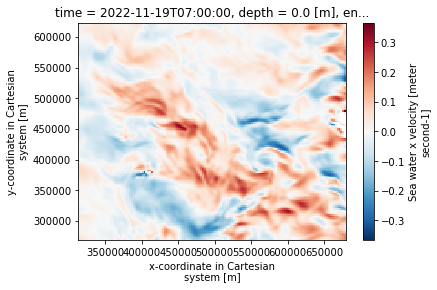

In [26]:
u_subset.sel(time=time_period[0]).plot()

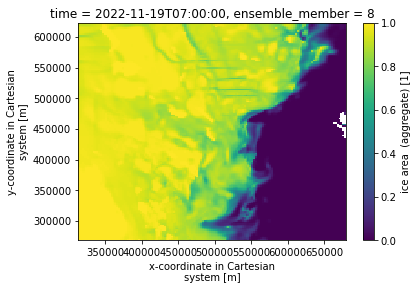

In [27]:
siconc_subset.sel(time=time_period[0]).plot()

In [18]:
#Defone teh buffer zone (Decided to take just one set big buffer)
buffer = 30

'''
#Calculate the maximum velocity to extend the frame according to drift
max_ice_u = ice_u_subset.max()
max_ice_v = ice_v_subset.max()
v_max = np.sqrt(max_ice_u**2 + max_ice_v**2)*total_time_diff/1000
print(f'maximum drift is {v_max.data:.1f} km')
#Taking into account that model resolution is 2.5 km calculate extra buffer zone
model_resolution = 2.5
#Near marginal ice zone it is better take even bigger buffer so it is doubled
buffer = 2*int(np.round(v_max.data/model_resolution))
'''
print(f'buffer zone is about {buffer} extra rows and columns')

buffer zone is about 30 extra rows and columns


In [19]:
#Extend area according to the buffer
min_r = min(r)-buffer
max_r = max(r)+buffer
min_c = min(c)-buffer
max_c = max(c)+buffer


# Assign the variable to 0 if it is negative
min_r = 0 if min_r < 0 else min_r
max_r = 0 if max_r < 0 else max_r
min_c = 0 if min_c < 0 else min_c
max_c = 0 if max_c < 0 else max_c
min_r, max_r, min_c, max_c

(437, 638, 0, 190)

In [20]:
# Extract the subset based on the new bounds
X_subset = X[min_c:max_c+1]
Y_subset = Y[min_r:max_r+1]
lon_subset = lon[min_r:max_r+1, min_c:max_c+1]
lat_subset = lat[min_r:max_r+1, min_c:max_c+1]

#pick ensmble
ensemble = 8
time_subset = time

ice_u_subset = ice_u.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min_r:max_r+1, min_c:max_c+1].fillna(np.nan)
ice_v_subset = ice_v.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min_r:max_r+1, min_c:max_c+1].fillna(np.nan)
siconc_subset  = siconc.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min_r:max_r+1, min_c:max_c+1].fillna(np.nan)
 
Vwind_subset  = Vwind.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)
Uwind_subset  = Uwind.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)

#v = v.squeeze(dim='depth')
#u = u.squeeze(dim='depth')
v_subset  = v.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan) #take into account depth arraywhen clipping
u_subset  = u.sel(time=slice(t_start,t_end), ensemble_member = ensemble)[:,min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)

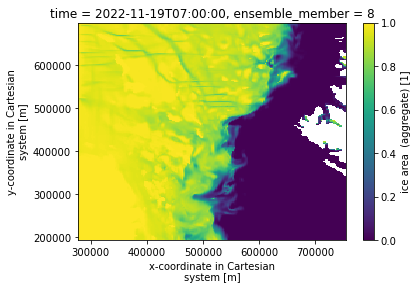

In [21]:
siconc_subset.sel(time=time_period[0]).plot()

### Calculating total hourly integrated (cumulative) displacements for drift_driven warping

In [6]:
from model_data_prep import cumulative_ice_displacement

In [23]:
xx, yy, int_dx, int_dy = cumulative_ice_displacement(X_subset,Y_subset, ice_u_subset, ice_v_subset,time_period, time_diff_start,time_diff_end)


1 hour done
2 hour done
3 hour done
4 hour done
5 hour done
6 hour done
7 hour done
8 hour done
9 hour done
10 hour done
11 hour done
12 hour done
13 hour done
14 hour done
15 hour done
16 hour done
17 hour done
18 hour done
19 hour done
20 hour done
21 hour done
22 hour done
23 hour done
24 hour done
25 hour done
26 hour done


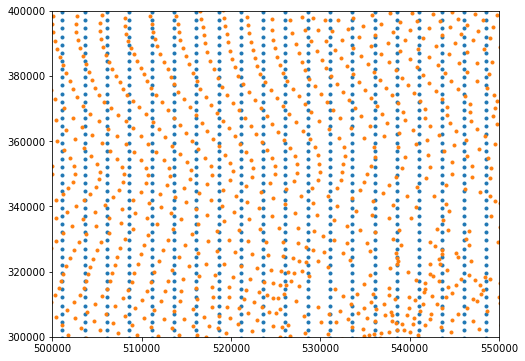

In [24]:
space_step=1

plt.figure(figsize=(8, 6))

plt.plot(xx[0][::space_step], yy[0][::space_step], '.')
#plt.plot(xx[10][::space_step], yy[10][::space_step], '.')
plt.plot(xx[26][::space_step], yy[26][::space_step], '.')
plt.xlim([5e5, 5.5e5])
plt.ylim([3e5, 4e5])

plt.show()

### Calculating hourly non-cummulative displacements for image-driven warping


In [25]:
from model_data_prep import non_cumulative_ice_displacement

In [26]:
xx_hourly, yy_hourly, hourly_dx, hourly_dy = non_cumulative_ice_displacement(X_subset,Y_subset, ice_u_subset, ice_v_subset,time_period, time_diff_start,time_diff_end)

1 hour done
2 hour done
3 hour done
4 hour done
5 hour done
6 hour done
7 hour done
8 hour done
9 hour done
10 hour done
11 hour done
12 hour done
13 hour done
14 hour done
15 hour done
16 hour done
17 hour done
18 hour done
19 hour done
20 hour done
21 hour done
22 hour done
23 hour done
24 hour done
25 hour done
26 hour done


### Export hourly dipslacement to csv files  according to further use 
for visualizing in qgis it's better to use displacement in format of dx dy, as input to current Chalmers algorithm lon2 lat2 format works better.

In [28]:
from model_data_prep import displacement_dxdy_to_csv, displacement_lon2lat2_to_csv, transform_to_geographic_coordinates

In [31]:
output_dir_subset1 = r'/home/jovyan/data/model_data_processing_output/hourly_cumulative_drift_csv/'

In [34]:
#Transforms coordinates from a given projection (defined by the model_proj4 string) to the Geographic Coordinate System (longitude and latitude).
int_lon, int_lat = transform_to_geographic_coordinates(xx, yy, model_proj4)

writing

In [40]:
displacement_dxdy_to_csv(output_dir_subset1, int_lon, int_lat, int_dx, int_dy, time_period)

In [41]:
displacement_lon2lat2_to_csv(output_dir_subset1, int_lon, int_lat, time_period)

In [29]:
output_dir_subset2 = r'/home/jovyan/data/model_data_processing_output/hourly_non-cumulative_drift_csv/'

In [32]:
#Transforms coordinates from a given projection (defined by the model_proj4 string) to the Geographic Coordinate System (longitude and latitude).
lon_hourly, lat_hourly = transform_to_geographic_coordinates(xx_hourly, yy_hourly, model_proj4)

writing

In [33]:
displacement_dxdy_to_csv(output_dir_subset2, lon_hourly, lat_hourly, hourly_dx, hourly_dy, time_period)

In [34]:
displacement_lon2lat2_to_csv(output_dir_subset2,  lon_hourly, lat_hourly, time_period)